In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import math
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/큐슈제강_조업데이터시트_2024년_전체합본.csv', low_memory=False)

# Check and remove rows with missing (NaN) values
missing_count = df.isnull().sum().sum()

if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2679


In [3]:
target = '사용전력량'

# Convert to numeric, drop rows that couldn't be converted (20240101-1)
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['A부스러기\u3000친'].notna()]
df = df[df['와셔 친'].notna()]

# Removes SC410 entries
lower_bound = 9000
upper_bound = 500000000

# Apply filter
df = df[df['강번'].between(9000, 500000000)]

# Outlier removal
if target in df.columns:
    initial_count_oxygen = len(df)
    df = df[df[target] >= 15000]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {target} < 15000.")
else:
    print(f"Warning: '{target}' column not found.")

if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where 'Precipitation (mm)' > 05.")
else:
    print(f"Precipitation (mm)' column not found.")

Removed 3 rows where 사용전력량 < 15000.
Removed 1 rows where 'Precipitation (mm)' > 05.


In [4]:
variables = ['취부회수', '연회회수', 'CaO', 'C-inj(佐山)', '장입량t', 'Precipitation (mm)', 'Pressure_SeaLevel (hPa)']

In [5]:
X = df[variables]
y = df[target]

# Sequential split (first 70% for training, last 30% for testing)
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# MLR

In [6]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


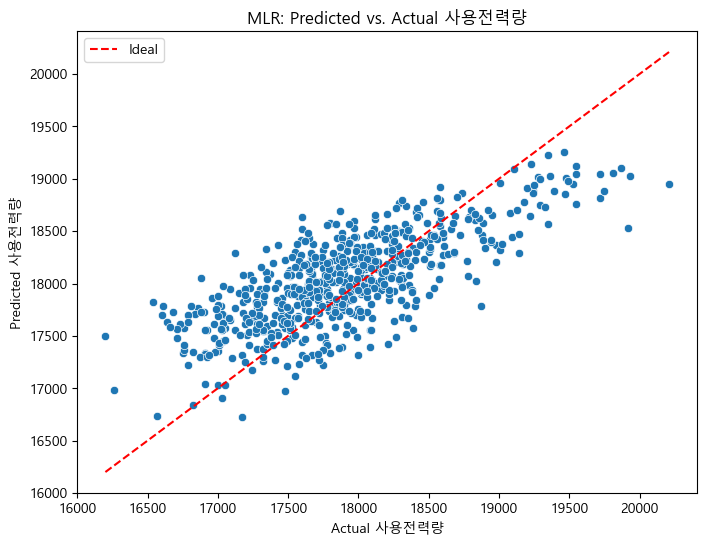


--- Model Evaluation ---
RMSE: 440.6516257653582
R² Score: 0.5161141478460516

Intercept: 14533.830611431338
Coefficients:
  취부회수: -46.06899424269691
  연회회수: -54.79429899675014
  CaO: 0.6842568073739521
  C-inj(佐山): 3.820576405080125
  장입량t: 4.7365176124392985
  Precipitation (mm): 32.922517981663724
  Pressure_SeaLevel (hPa): 1.6487731928554838


In [7]:
y_pred = model.predict(X_test)

# Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.title(f'MLR: Predicted vs. Actual {target}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()

plt.show()

MSE = mean_squared_error(y_test, y_pred)

# Evaluation metrics
print("\n--- Model Evaluation ---")
rmse = np.sqrt(MSE)
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))
print("\nIntercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef}")

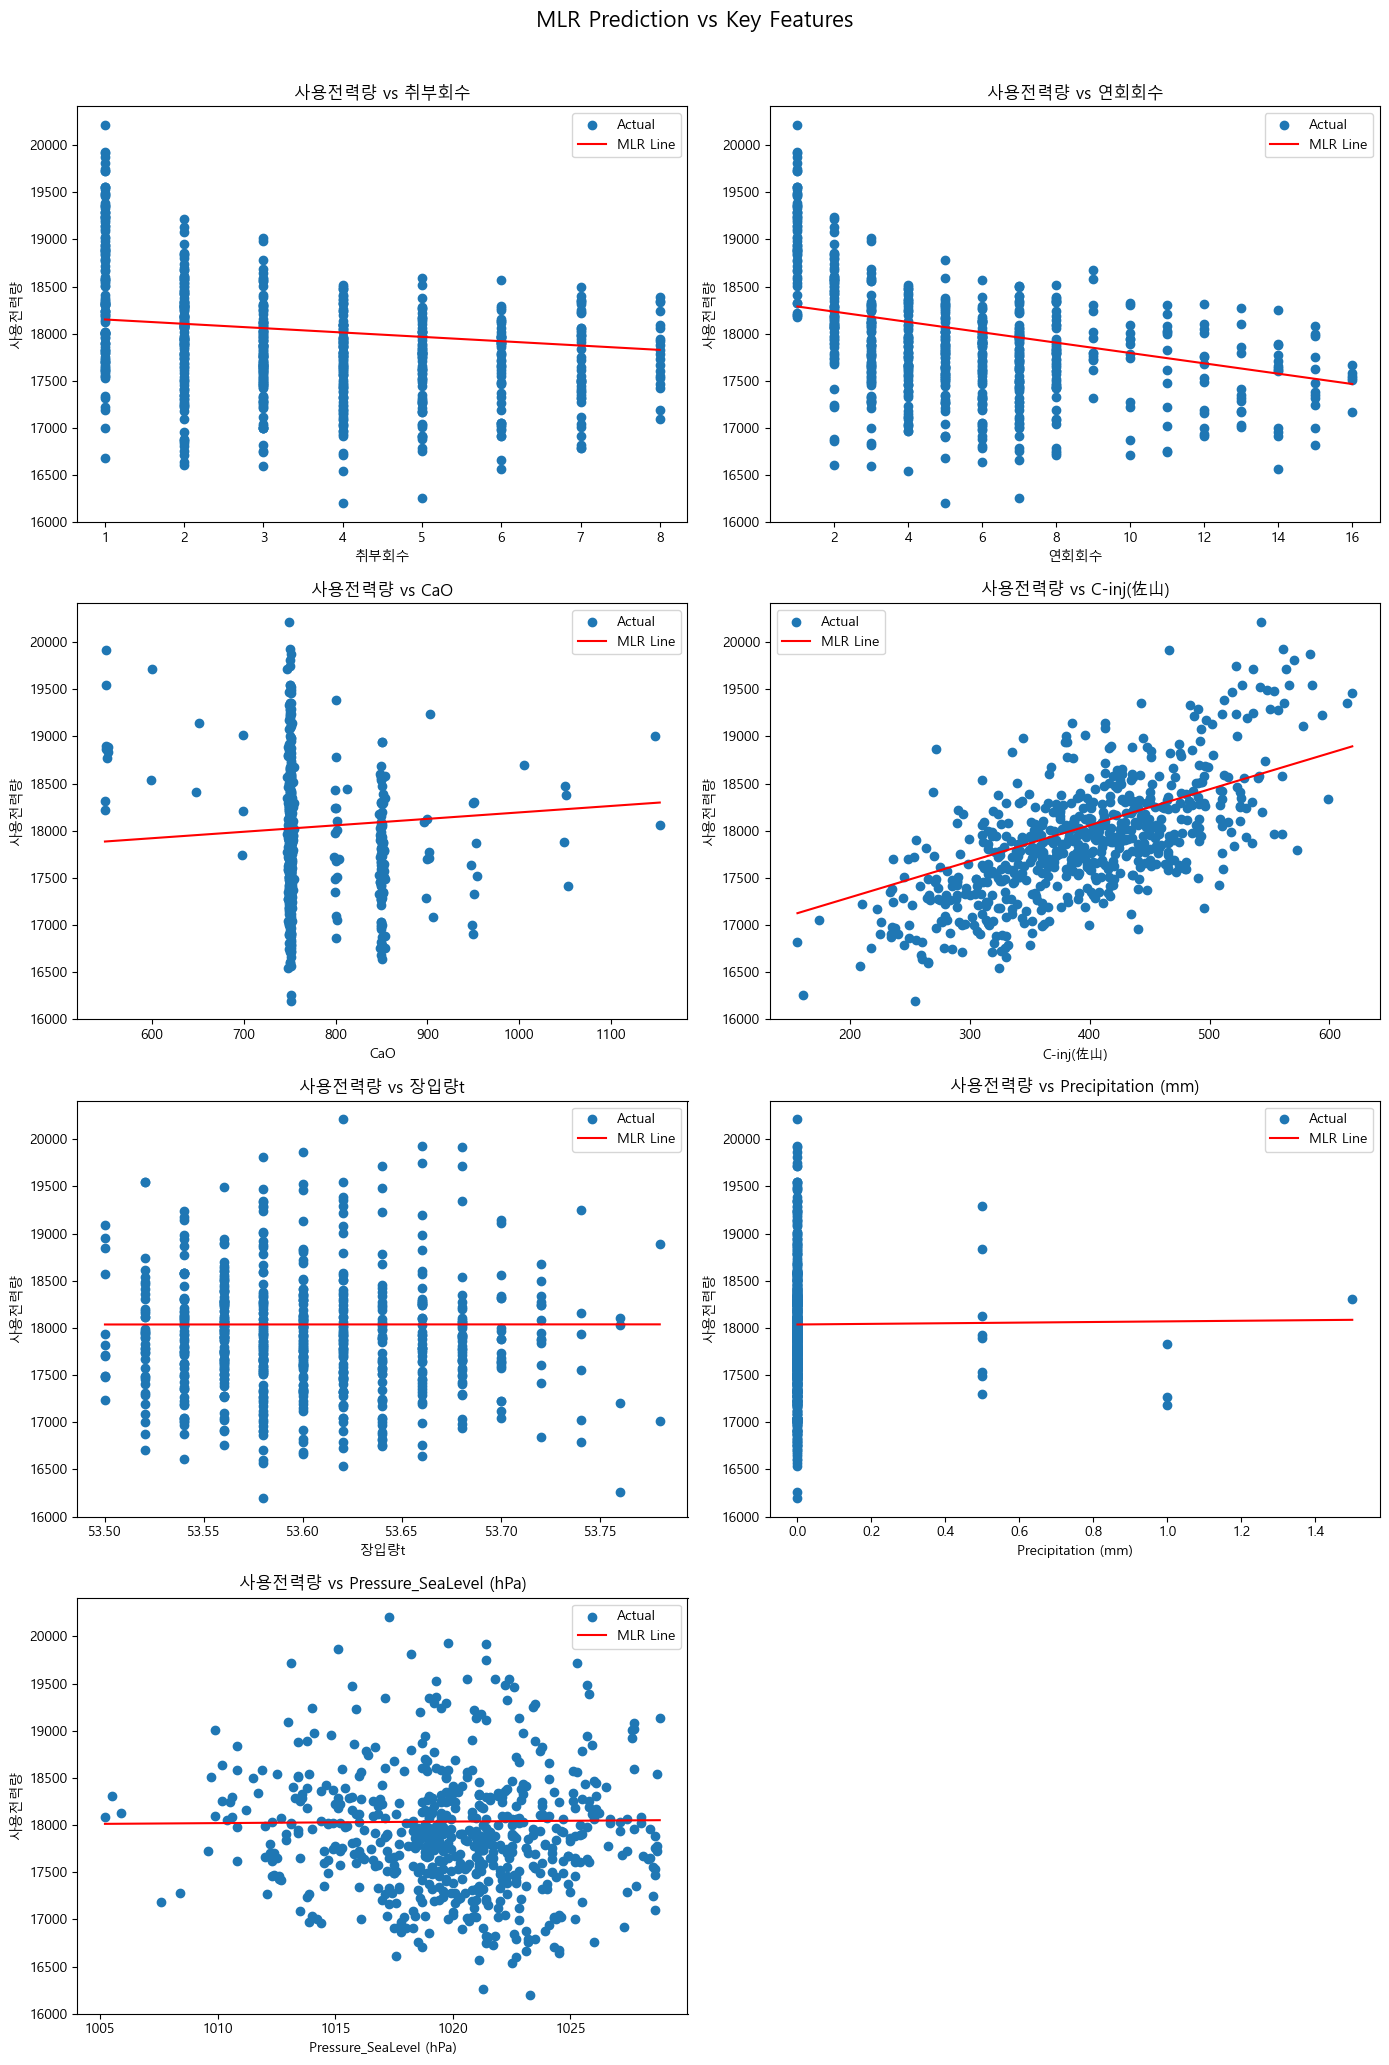

In [8]:
feature_means = X_test.mean()

# Subplots
n_vars = len(variables)
cols = 2
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Generate plots
for i, var in enumerate(variables):
    ax = axes[i]
    x_vals = np.linspace(X_test[var].min(), X_test[var].max(), 100)
    y_vals = np.full_like(x_vals, model.intercept_, dtype=float)
    for j, col in enumerate(X_test.columns):
        if col == var:
            y_vals += model.coef_[j] * x_vals  # vary only current variable
        else:
            y_vals += model.coef_[j] * feature_means[col]  # fix others at mean

    # Scatter actual vs predicted
    ax.scatter(X_test[var], y_test, alpha=1, label='Actual')
    ax.plot(x_vals, y_vals, color='red', label='MLR Line')
    ax.set_xlabel(var)
    ax.set_ylabel(f'{target}')
    ax.set_title(f'{target} vs {var}')
    ax.legend()

# Remove any unused axes (if total axes > variable count)
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('MLR Prediction vs Key Features', fontsize=16, y=1.03)
plt.show()

# Time Series Data MLR

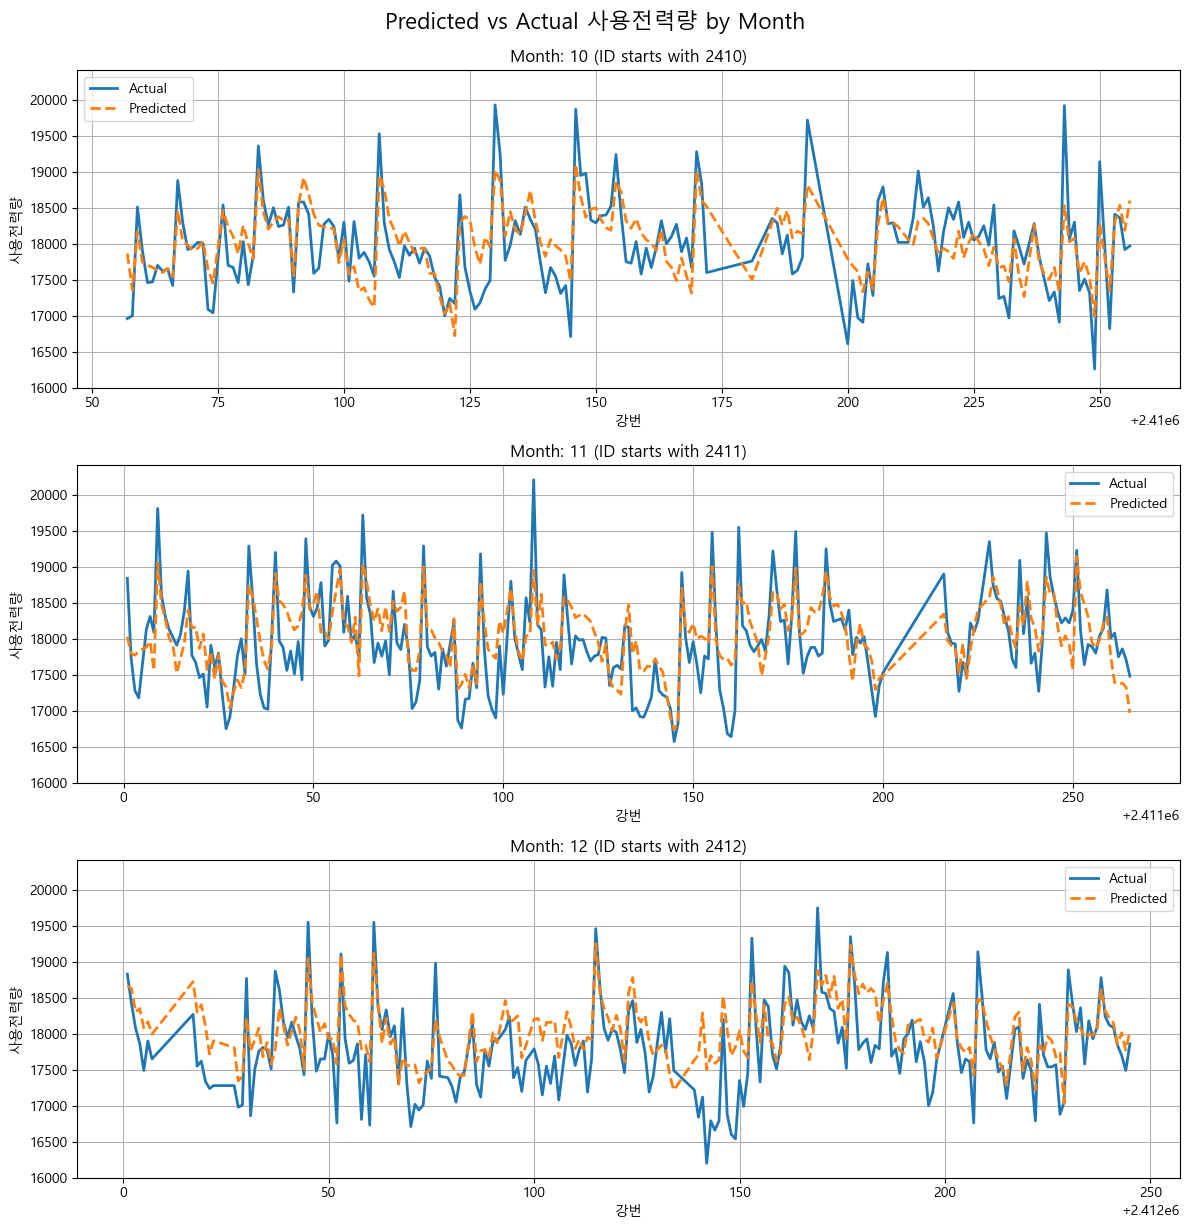

In [9]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual'] = y_test.values
id_aligned_df['Predicted'] = y_pred

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)
months = [10, 11, 12]

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel(f'{target}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle(f'Predicted vs Actual {target} by Month', fontsize=16, y=1.02)
plt.show()

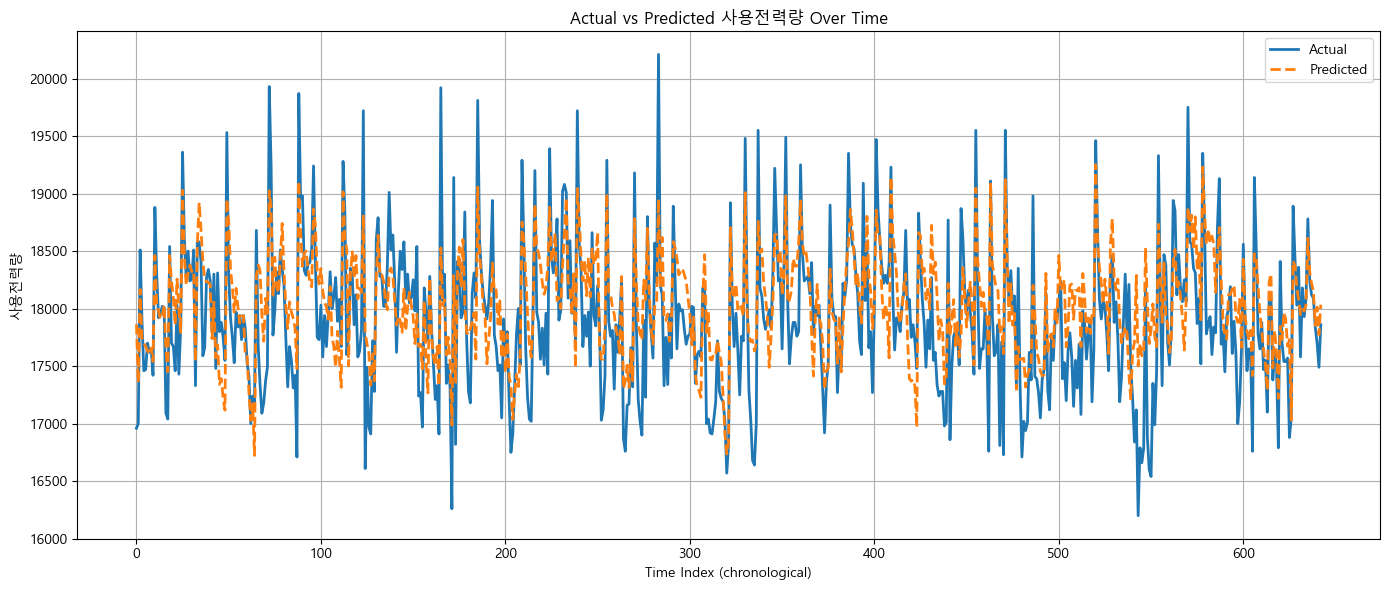

In [10]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual'], label='Actual', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('사용전력량')
plt.title('Actual vs Predicted 사용전력량 Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost

In [11]:
# XGBoost Model set up
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth= 4,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

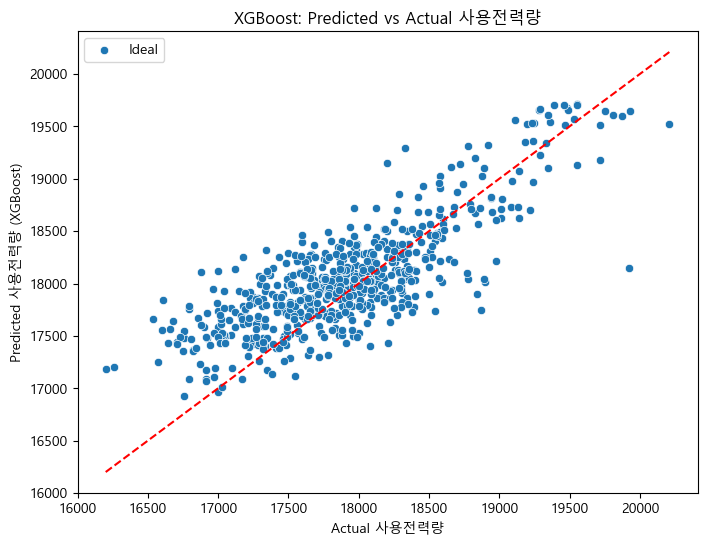


--- XGBoost Model Evaluation ---
XGBoost RMSE: 401.3186060765617
R² Score: 0.5986430746232196


In [12]:
# XGBoost Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=xgb_pred)
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target} (XGBoost)')
plt.title(f'XGBoost: Predicted vs Actual {target}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Ideal'])
plt.show()

# Evaluation
print("\n--- XGBoost Model Evaluation ---")
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGBoost RMSE:", rmse_xgb)
print("R² Score:", r2_score(y_test, xgb_pred))

In [ ]:
# Features to plot
features = variables
n_features = len(features)

X_test = X_test.astype('float')

# Adjust grid size based on number of features
rows = (n_features + 1) // 2 
fig, axes = plt.subplots(rows, 2, figsize=(16, rows * 3))
axes = axes.flatten()

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel(f'{target}')
    ax.set_title(f'{target} vs {feature}')
    ax.legend()

# Remove unused axes
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

# Improve layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle(f'{target} vs Features with Partial Dependence (XGBoost)', fontsize=16)
plt.show()

In [ ]:
importances = xgb_model.feature_importances_
for var, imp in sorted(zip(X.columns, importances), key=lambda x: -x[1]):
    print(f"{var}: {imp}")

# Time Series Data XGBoost

In [ ]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual'] = y_test.values
id_aligned_df['Predicted'] = xgb_pred

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)
months = [10, 11, 12]

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel(f'{target}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle(f'Predicted vs Actual {target} by Month', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual'], label='Actual', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('사용전력량')
plt.title('Actual vs Predicted 사용전력량 Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Miscellaneous

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X)